In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

import pandas as pd

options = Options()
options.headless = False

driver = webdriver.Chrome(options=options, service=ChromeService(
    ChromeDriverManager().install()))
na_url = 'https://www.naughtyamerica.com/new-porn-videos?page=1'


In [2]:
def scrape_na(driver, page):
    na_url = f'https://www.naughtyamerica.com/new-porn-videos?page={page}'
    driver.get(na_url)

    scenes = driver.find_elements(
        By.CSS_SELECTOR, '.scene-list .scene-grid-item a.contain-img')
    scenes_img = driver.find_elements(
        By.CSS_SELECTOR, '.scene-list .scene-grid-item a.contain-img .main-scene-img')
    scene_sites = driver.find_elements(By.CSS_SELECTOR, '.site-title')
    scene_dates = driver.find_elements(By.CSS_SELECTOR, 'p.entry-date')
    scene_durations = driver.find_elements(By.CSS_SELECTOR, '.scene-grid-item')
    scene_flags = driver.find_elements(
        By.CSS_SELECTOR, 'p.entry-date span.flag-contain')
    scene_performers = driver.find_elements(
        By.CSS_SELECTOR, 'p.contain-actors')

    scene_title_list = []
    scene_id_list = []
    scene_img_list = []
    scene_site_list = []
    scene_date_list = []
    scene_duration_list = []
    scene_flag_list = []
    scene_vr_list = []
    scene_creampie_list = []
    scene_anal_list = []
    scene_remaster_list = []
    scene_performer_list = []

    for sc_in in range(len(scenes)):
        try:
            scene_title = scenes[sc_in].get_attribute('title')
        except:
            scene_title = None
        scene_id = scenes[sc_in].get_attribute('data-scene-id')
        scene_img_url = scenes_img[sc_in].get_attribute('srcset')
        scene_site = scene_sites[sc_in].text
        scene_date = scene_dates[sc_in].text
        spl = scene_date.split(' ')
        scene_date = f"{spl[0]} {spl[1]} {spl[2]}"
        try:
            scene_duration = scene_durations[sc_in].find_elements(
                By.CSS_SELECTOR, 'p.scene-runtime')[0].text
        except:
            scene_duration = None

        flag_array = scene_flags[sc_in].find_elements(By.CSS_SELECTOR, 'a')
        farray = []
        for idx, f in enumerate(flag_array):
            farray.append(f.text)

        scene_flag = ", ".join(farray)

        scene_vr = 'VR' in farray
        scene_creampie = 'CREAMPIE' in farray
        scene_anal = 'ANAL' in farray
        scene_remaster = 'REMASTERED HD' in farray

        perf_array = scene_performers[sc_in].find_elements(
            By.CSS_SELECTOR, 'a')
        parray = []
        for idx, p in enumerate(perf_array):
            parray.append(p.text)
        scene_performer = ', '.join(parray)

        scene_id_list.append(scene_id)
        scene_title_list.append(scene_title)
        scene_img_list.append(scene_img_url)
        scene_site_list.append(scene_site)
        scene_date_list.append(scene_date)
        scene_duration_list.append(scene_duration)
        scene_flag_list.append(scene_flag)
        scene_vr_list.append(scene_vr)
        scene_creampie_list.append(scene_creampie)
        scene_anal_list.append(scene_anal)
        scene_remaster_list.append(scene_remaster)
        scene_performer_list.append(scene_performer)

        print(f"{page}|{sc_in+1}. {scene_title}")

    df = pd.DataFrame({
        'id': scene_id_list,
        'title': scene_title_list,
        'site': scene_site_list,
        'performer': scene_performer_list,
        'duration': scene_duration_list,
        'release_date': scene_date_list,
        'img_url': scene_img_list,
        'flag': scene_flag_list,
        'is_vr': scene_vr_list,
        'is_creampie': scene_creampie_list,
        'is_anal': scene_anal_list,
        'is_remaster': scene_remaster_list
    })
    return df


In [3]:
scenes_df = pd.DataFrame()
for page in range(1,3):
    d = scrape_na(driver, page)
    scenes_df = pd.concat([scenes_df, d]).reset_index(drop=True)


1|1. Chanel Camryn & Kyle Mason in Naughty Bookworms
1|2. Lilly Hall & James Angel in Neighbor Affair
1|3. India Summer & Zane in My First Sex Teacher
1|4. Reagan Foxx & Lucas Frost in Mrs. Creampie
1|5. Charlotte Sins & Dan Damage in Naughty America
1|6. Dee Williams & Josh Rivers in Naughty America
1|7. Dharma Jones & Nade Nasty in My Sister's Hot Friend
1|8. Riley Reign & Lawson Jones in Naughty America
1|9. Nicole Aniston & Ryan Driller in Dirty Wives Club
1|10. Syren De Mer & Lawson Jones in Seduced By A Cougar
1|11. Bella Blu & Hazel Moore & Jewelz Blu & Dan Damage in Party Girls
1|12. Callie Black & David Lee in My Girlfriend's Busty Friend
1|13. Shawna Leneé & Tony De Sergio in Naughty Bookworms
1|14. August Skye & Lucas Frost in My Wife's Hot Friend
1|15. Anna Claire Clouds & Hime Marie & Kylie Rocket & Dan Damage in Naughty America
1|16. Kiki Klout & Lucas Frost in My Friend's Hot Mom
1|17. Adira Allure & Alex Jones in I Have a Wife
1|18. Maddy O'Reilly & Chad White in My Wif

In [4]:
scenes_df.to_excel('../../../data/xxx/na_20221107.xlsx')

Thumbnail Viz


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from highlight_text import fig_text, ax_text

from PIL import Image
import urllib
import json
import os
import math

plt.style.use('../../../assets/stylesheets/soc_base.mplstyle')


In [8]:
def draw_thumbnails(data, nrows=2, ncols=2, offset=0):
    nrows, ncols = nrows*2, ncols
    w, h = 4.5, 1.8
    fig = plt.figure(figsize=(w*ncols, h*nrows), dpi=200)

    height_ratios = [(1/nrows)*2 if x %
                     2 == 0 else (1/nrows)/2 for x in range(nrows)]

    gspec = gridspec.GridSpec(
        ncols=ncols, nrows=nrows, figure=fig,
        height_ratios=height_ratios
    )
    gspec.update(wspace=0, hspace=0.1)

    counter = 0
    capt_counter = 0
    offset = offset

    for row in range(nrows):
        for col in range(ncols):
            if row % 2 == 0:
                ax = plt.subplot(gspec[row, col])
                ax.axis('off')
                try:
                    img_url = f"https:{data.iloc[offset+counter]['img_url']}"
                    scene_img = Image.open(urllib.request.urlopen(img_url))
                    ax.imshow(scene_img)
                    print(f"({offset+counter+1}/{len(data)}) {img_url}")
                    have = data.iloc[offset+counter]['have']
                    if have == True:
                        ax_text(
                            x=.95,
                            y=.95,
                            s=f'<DOWNLOADED>',
                            highlight_textprops=[
                                {'size': '12',
                                 'bbox': {'edgecolor': '#68bf9c',
                                          'facecolor': '#68bf9c',
                                          'pad': 2},
                                 'color': '#6f4404',
                                 'weight': 'bold'},
                            ],
                            ax=ax,
                            font='Karla',
                            ha='right',
                            size=10,
                            annotationbbox_kw={'xycoords': 'axes fraction'}
                        )
                except:
                    continue                

                counter += 1
            else:
                logo_ax = plt.subplot(
                    gspec[row, col],
                    anchor='NW'
                )
                logo_ax.axis('off')
                try:
                    performers = data.iloc[offset+capt_counter]['performer']
                    site = data.iloc[offset+capt_counter]['site']
                    release_date = data.iloc[offset +
                                             capt_counter]['release_date']
                    is_creampie = data.iloc[offset+capt_counter]['is_creampie']

                    ax_text(
                        x=0.03,
                        y=1,
                        s=f'<{performers}>\n<{site}>\n<{release_date}>',
                        highlight_textprops=[
                            {'weight': 'bold'},
                            {'size': '9'},
                            {'size': '8', 'color': '#121212'},
                        ],
                        ax=logo_ax,
                        font='Karla',
                        ha='left',
                        size=10,
                        annotationbbox_kw={'xycoords': 'axes fraction'}
                    )
                    if is_creampie == True:
                        ax_text(
                            x=.95,
                            y=1,
                            s=f'<Creampie>',
                            highlight_textprops=[
                                {'size': '8', 'bbox': {'edgecolor': 'red',
                                                       'facecolor': 'red', 'pad': 1}, 'color': 'white'},
                            ],
                            ax=logo_ax,
                            font='Karla',
                            ha='right',
                            size=10,
                            annotationbbox_kw={'xycoords': 'axes fraction'}
                        )
                except:
                    continue
                capt_counter += 1


In [9]:
sc_clean = pd.read_excel('../../../data/xxx/na-clean.xlsx', index_col=0)
sc_creampie = sc_clean[sc_clean['is_creampie'] == True]

selected_actor = pd.read_csv('../../../data/xxx/na-actor-list.csv',
                             index_col=0).reset_index()
selected_actor = list(selected_actor['name'])


In [10]:
data = sc_creampie.copy()
site_have = data[data['have'] == True].groupby(['site'])['title'].count(
).reset_index(name='have_count').sort_values('have_count', ascending=False)
site_clean = data.groupby(['site'])['title'].count().reset_index(
    name='count').sort_values(['count'], ascending=False)
site_clean = site_clean.merge(site_have, how='left', on='site', indicator=True)
site_clean['have_count'] = site_clean['have_count'].fillna(0)
site_clean['have_count'] = site_clean['have_count'].astype(int)
site_clean['possession'] = (
    site_clean['have_count'] / site_clean['count']) * 100
site_clean['possession'] = site_clean['possession'].round(2)
sitee = site_clean.sort_values('possession', ascending=True)
# sitee = site_clean[(site_clean['count']<=20) & (site_clean['possession']<=100)].sort_values('possession',ascending=True)


In [11]:
sc_by_actor = []
data = sc_creampie.copy()
for i in range(len(data)):    
    actors = data.iloc[i]['performer'].split(', ')
    for act in enumerate(actors):
        sc_by_actor.append({
            'id': data.iloc[i]['id'],
            'title': data.iloc[i]['title'],
            'actor': act[1],
            'site' : data.iloc[i]['site'],
            'have' : data.iloc[i]['have']
        })
sc_by_actor = pd.DataFrame(sc_by_actor).reset_index(drop=True)
sc_by_actor = sc_by_actor[sc_by_actor['actor'].isin(selected_actor)].reset_index(drop=True)


In [12]:
s = sc_by_actor.groupby(['actor'])['title'].count().reset_index(name='count').sort_values(by='count',ascending=False)
t = sc_by_actor[sc_by_actor['have']==True].groupby(['actor'])['title'].count().reset_index(name='have_count').sort_values(by='have_count',ascending=False)
u = s.merge(t,how='left',on='actor',indicator=True)
u['have_count'] = u['have_count'].fillna(0)
u['have_count'] = u['have_count'].astype(int)
u['possession'] = (
    u['have_count'] / u['count']) * 100
u['possession'] = u['possession'].round(2)
u['not_have_count'] = u['count'] - u['have_count']
v = u[(u['possession']<100) & (u['possession']>0)].sort_values(['possession','have_count'],ascending=False)

(1/4) https://images4.naughtycdn.com/cms/nacmscontent/v1/scenes/naf/octaviabrick/scene/horizontal/800x534c.jpg 
(2/4) https://images5.naughtycdn.com/cms/nacmscontent/v1/scenes/mdhf/octaviabrad/scene/horizontal/800x534c.jpg 
(3/4) https://images3.naughtycdn.com/cms/nacmscontent/v1/scenes/mgbf/octaviadavid/scene/horizontal/800x534c.jpg 
(4/4) https://images3.naughtycdn.com/cms/nacmscontent/v1/scenes/mshf/octavialucas/scene/horizontal/800x534c.jpg 


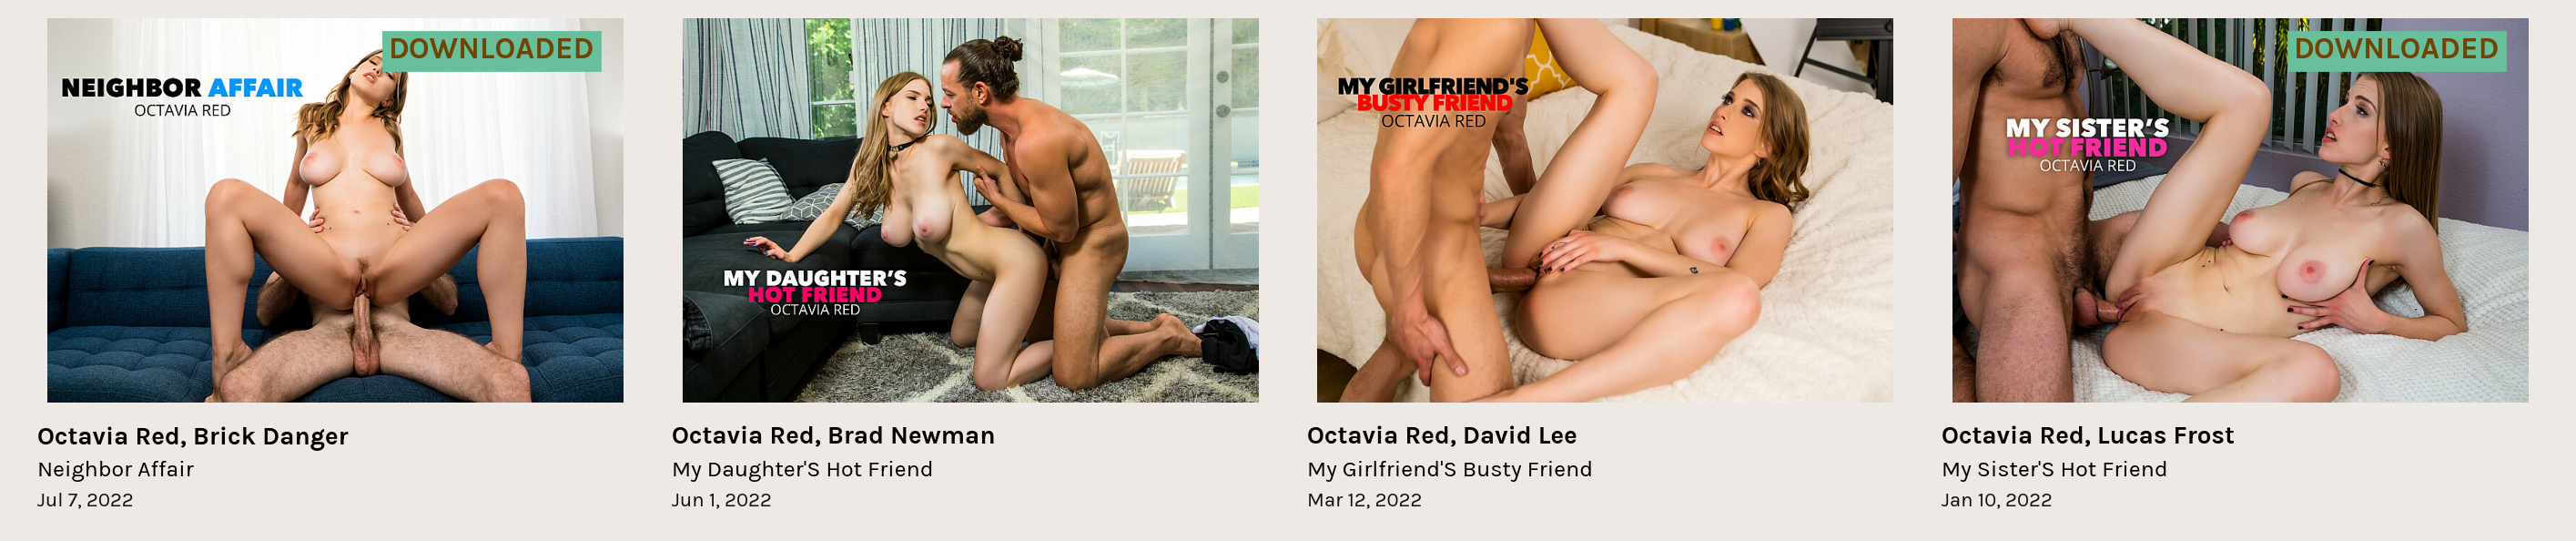

In [19]:
sc_selection = sc_clean.copy()

selected_actor = ["Octavia Red"]
a = '|'.join(selected_actor)
sc_selection = sc_selection[sc_selection['performer'].str.contains(a)]

# selected_site = ["Naughty Athletics"]
# sc_selection = sc_selection[sc_selection['site'].isin(selected_site)]

# sc_selection = sc_selection[sc_selection['is_creampie'] == True]
# sc_selection = sc_selection[sc_selection['have'] != True]

page = 1

limit = 20
offset = (page-1)*limit

if len(sc_selection) > limit:
    sz = limit
else:
    sz = len(sc_selection)

if sz < 4:
    ncols = sz
else:
    ncols = 4
nrows = math.ceil(sz/ncols)

draw_thumbnails(data=sc_selection, nrows=nrows, ncols=ncols, offset=offset)
